# Subject
Our goal is to analyze this dataset, to offer a visualization of each elements of the dataset, and to try to predict the label correspond to the features. (supervised classification problem).

## The Dataset
The dataset represents hand-written digits (from 0 to 9). The objective is to perform some computer vision: given an image of a digit, our model's goal is to label that digit correctly, with the best accuracy possible. 

## Basic methodology
In a first time, we will import the dataset and try to visualize some digits, in order to better understand what we are dealing with.

In a secon time, we will perform some dimensonality reduction (unsupervised learning). This will be done in order to make it easier to apply complex models to our data.

In a third time, we will test out different types of algorithms(ML and DL), and fine-tune the best ones.

In a fourth time, we will try to apply some ensemble learning in order to improve even more our model.

In a fifth time, we will explore new ways to improve our model: data augmentation. For this, we will try to generate more data (simpling shiftings, cleaning), and GANs to generate data.

The librairies we will use are:
- pandas, numpy, seaborn, matplotlib for the basics
- sklearn, xgboost and DESlib for the machine learning model training.
- tensorflow, keras for the deep learning model training and GANs.


## Suggested improvements: 
- Try on full data instead of PCA first. (Might need more power)
- Try measure precision and recall instead of accuracy, to understand better how the classifier performs
- Try applying loop detection first with OpenCV, to improve the detection of 8's
- Try improving the differenciation between 5's and 3's (OvO?)
- Try other parameters for the models (difficult, because I don't have enough computational power)
- Try apllying ROC curve and AUC curve methodology, but by plotting one class against another
- Do fine-tuning on the deep learning model
- Put things that I re-use in functions, the same way I started doing it in deep learning training (WIP)
- Try other combinations of layer types in the deep learning training
- Try stacking on the full dataset, with another final estimator (randomforest)
- Try using OpenCV
- Try models with the augmented datasets
- Try optimizing GAN, as it is very long to process for now
- Add checkpoints to the GAN model, as it is long to train

# Setup

In [27]:
# Data manipulation
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import os
import

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn                    import metrics, svm
from sklearn.linear_model           import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import preprocessing
from sklearn import manifold

#Advanced Ensemble and Stacking techniques
# Example of DCS techniques
from deslib.dcs import OLA
from deslib.dcs import MCB
# Example of DES techniques
from deslib.des import KNORAE
from deslib.des import DESP
from deslib.des import KNORAU
from deslib.des import METADES

# Data import

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [81]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

Creating the input and output matrix:

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Checking image sizes:

In [6]:
28 * 28

784

**Conclusion:** The dataset is composed of 70 000 rows, each representing a image of a digit. Each cell is a value from 0 to 255 (the color of the pixel). The labels are values from 0 to 9.

# Exploratory Data Analysis

As this is a computer vision problem, and the dataset is already premade by sklearn, we won't do a classic exploratory analysis as for the regression problem. In this part, we will try to understand how our features are related to the data, by defining functions to plot the digits:

In [69]:
def plot_digit(data):
    data = np.array(data, dtype='uint8')
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    instances = np.array(instances, dtype='uint8')
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

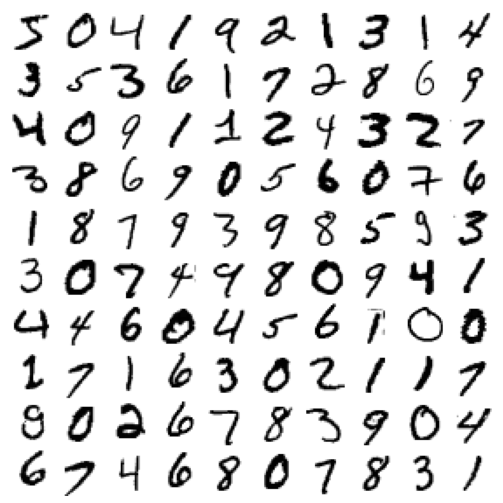

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

# Preprocessing
Again, in this problem we will not do a proper feature engineering step. Instead, as we are facing a lot of features for each picture (784), and the models we plan to use are quite expensive to use computationally, we will try to proceed with some **dimensonality reduction** first.

## Principal Component Analysis

In [50]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [51]:
d

154

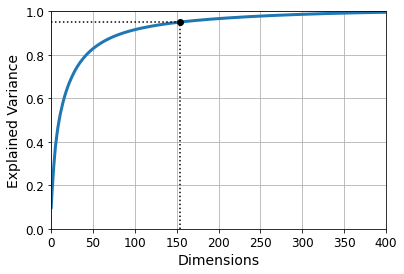

In [52]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()

We will try to plot what the compresses images look like, by using an inverse PCA:

In [4]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

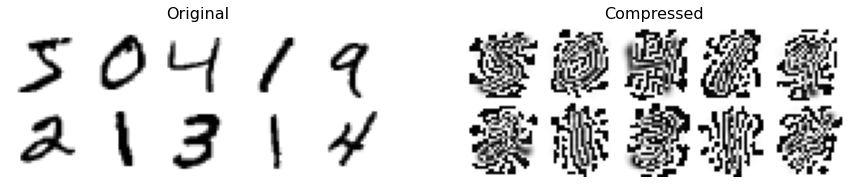

In [54]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
train=X_train[:10]
recovered=X_recovered[:10]
plot_digits(train, images_per_row=5)
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(recovered, images_per_row=5)
plt.title("Compressed", fontsize=16)

Scaling the final dataset:

After dimensonality reduction, we end with 154 features instead of 784

## Scaling

Scaling to improve speed for some models

In [5]:
scaler = preprocessing.StandardScaler().fit(X_reduced)
X_processed = scaler.transform(X_reduced)

Splitting dataset to avoid data snooping:

## Splitting dataset

**WARNING**: Always split the dataset after pre-processing, or be carefull to pre-process both training and test set.

In [6]:
X_final, X_test, y_train, y_test = X_processed[:60000], X_processed[60000:], y[:60000], y[60000:]

# Select and train a model

Our model needs to be MULTICLASS (more then 2 outputs possible), but not multilabel or multioutput.

## Logistic regression (softmax)

### Training

OVR supports multiclass, and is the most appropriate for binary data, but as we applied a PCA, the features are not binary anymore, so we use multinomial. C defines how strong the l2 penalty is. We will fine-tune those parameters later.

Please note that without feature scaling, the Log Reg does not converge with 1000 iterations.

In [37]:
log_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42, max_iter=1000)
log_reg.fit(X_final, y_train)

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial',
                   random_state=42)

In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(log_reg, X_final, y_train, cv=5, scoring="accuracy", verbose=3)

array([0.92258333, 0.91625   , 0.918     , 0.91316667, 0.9255    ])

### Preprocessing our logistic regression with unsupervised learning (Clustering), and fine-tuning parameters with gridSearch

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42, max_iter=1000)),
])
pipeline.fit(X_final, y_train)

C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(C=10, max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=42))])

In [67]:
#Long to run (>2h)
from sklearn.model_selection import GridSearchCV
param_grid = [
    dict(kmeans__n_clusters=[5, 10, 50]
         ,log_reg__solver=['lbfgs','saga']
        ,log_reg__C=[1,5,10]
         ,log_reg__max_iter=[5000,10000]
        )    
  ]
grid_clf = GridSearchCV(pipeline, param_grid, cv=2, verbose=2)
grid_clf.fit(X_final, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time=  26.4s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time=  35.6s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=saga; total time=  26.6s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=saga; total time=  21.5s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time=  24.7s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time=  36.4s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=saga; total time=  28.1s
[CV] END kmeans__n_clusters=5, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=saga; total time=  20.8s
[CV] END kmeans__n_clusters=5, log_reg__C=5, log_re

C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time= 2.0min


C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time= 1.9min
[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=saga; total time= 2.8min
[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=5000, log_reg__solver=saga; total time= 3.1min
[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time= 2.1min
[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time= 2.1min
[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=saga; total time= 3.0min
[CV] END kmeans__n_clusters=50, log_reg__C=1, log_reg__max_iter=10000, log_reg__solver=saga; total time= 3.2min


C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time= 1.9min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time= 1.7min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=5000, log_reg__solver=saga; total time= 3.1min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=5000, log_reg__solver=saga; total time= 3.6min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time= 2.0min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time= 2.2min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=10000, log_reg__solver=saga; total time= 3.1min
[CV] END kmeans__n_clusters=50, log_reg__C=5, log_reg__max_iter=10000, log_reg__solver=saga; total time= 3.9min


C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time= 2.0min


C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=5000, log_reg__solver=lbfgs; total time= 2.0min
[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=5000, log_reg__solver=saga; total time= 3.3min
[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=5000, log_reg__solver=saga; total time= 4.0min
[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time= 1.9min
[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=10000, log_reg__solver=lbfgs; total time= 2.1min
[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=10000, log_reg__solver=saga; total time= 3.3min
[CV] END kmeans__n_clusters=50, log_reg__C=10, log_reg__max_iter=10000, log_reg__solver=saga; total time= 4.0min


C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(C=10, max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=42))]),
             param_grid=[{'kmeans__n_clusters': [5, 10, 50],
                          'log_reg__C': [1, 5, 10],
                          'log_reg__max_iter': [5000, 10000],
                          'log_reg__solver': ['lbfgs', 'saga']}],
             verbose=2)

In [69]:
grid_clf.best_params_

{'kmeans__n_clusters': 50,
 'log_reg__C': 10,
 'log_reg__max_iter': 5000,
 'log_reg__solver': 'lbfgs'}

In [70]:
grid_clf.best_score_

0.8108333333333333

The accuracy seems worse while using unsupervised learning as pre-processing. We will not use it hereafter.

## Support Vector Machine

As SVMs do not support natively multiclass classification, we will use manually the OneVersusRest methodology.

### Training

We are trying it on the first 10 000 rows, as it was very long with more.

In [140]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42), n_jobs=-1)
ovr_clf.fit(X_final[:10000], y_train[:10000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42), n_jobs=-1)

Checking that we have 10 classes:

In [78]:
len(ovr_clf.estimators_)

10

In [79]:
cross_val_score(ovr_clf, X_final[:10000], y_train[:10000], cv=3, scoring="accuracy")

array([0.94181164, 0.94689469, 0.93309331])

Here we have better results then the Logistic regression!

### Identifiying weaknesses thanks to the confusion matrix

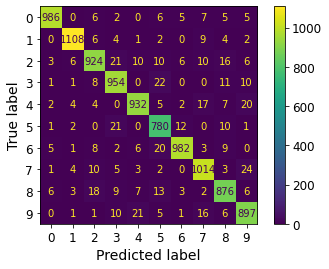

In [93]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(ovr_clf, X_final[:10000], y_train_pred[:10000]) 

We can here conclude that our classifier does things correctly: a lot of big values are on the diagonale. Yet, it might be possible that some classes are not as represented as others, or are misclassified more often then others. Let's divide each value in the matrix by the number of occurences of the corresponding class:

In [92]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(ovr_clf, X_final[:10000], y_train[:10000], cv=3)
conf_mx = confusion_matrix(y_train[:10000], y_train_pred)
conf_mx

array([[ 982,    0,    3,    1,    2,    1,    5,    1,    6,    0],
       [   0, 1101,    9,    1,    4,    2,    1,    5,    3,    1],
       [   8,    9,  920,    8,    5,    0,    8,   10,   22,    1],
       [   2,    4,   21,  949,    0,   21,    2,   10,   12,   11],
       [   0,    2,   10,    0,  929,    0,    6,    3,    6,   24],
       [   6,    3,    9,   23,    5,  777,   20,    2,   13,    5],
       [   5,    1,    6,    0,    2,   14,  982,    0,    3,    1],
       [   6,    9,   12,    0,   17,    0,    3, 1005,    2,   16],
       [   6,    5,   16,   11,    7,   11,    9,    3,  869,    7],
       [   7,    2,    6,   14,   22,    1,    0,   27,    7,  892]],
      dtype=int64)

In [90]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Let's fill the diagonale with zeros, to focus on the mistakes of the classifier:

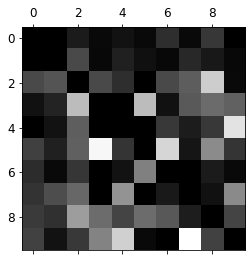

In [94]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

It looks like 5 and 3 are often misclassified as each other. 9 and 7 too. That is explained by the fact that those numbers can look at lot alike. We will try to focus on improving that in the data augmentation part.

## K-Nearest Neighbours (Instance based algorithm)

### Training and evaluating

In [100]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_final, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [101]:
cross_val_score(knn_clf, X_final, y_train, cv=3, scoring="accuracy")

array([0.902  , 0.90225, 0.90735])

### Fine-tuning with Gridsearch

In [102]:
#Long to run
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3)
grid_search.fit(X_final, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END .................n_neighbors=3, weights=uniform; total time=  11.4s
[CV 2/3] END .................n_neighbors=3, weights=uniform; total time=  11.6s
[CV 3/3] END .................n_neighbors=3, weights=uniform; total time=  11.5s
[CV 1/3] END ................n_neighbors=3, weights=distance; total time=  11.2s
[CV 2/3] END ................n_neighbors=3, weights=distance; total time=  11.7s
[CV 3/3] END ................n_neighbors=3, weights=distance; total time=  11.4s
[CV 1/3] END .................n_neighbors=4, weights=uniform; total time=  16.8s
[CV 2/3] END .................n_neighbors=4, weights=uniform; total time=  16.6s
[CV 3/3] END .................n_neighbors=4, weights=uniform; total time=  16.6s
[CV 1/3] END ................n_neighbors=4, weights=distance; total time=  15.7s
[CV 2/3] END ................n_neighbors=4, weights=distance; total time=  15.8s
[CV 3/3] END ................n_neighbors=4, weigh

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [103]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [104]:
grid_search.best_score_

0.9038666666666667

## Random Forests

GridSearch to immediately fine-tune parameters:

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 100, 200], 'max_depth': [10, 50, 100]},
  ]

forest_clf = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_clf, param_grid, cv=2,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_final, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_depth': [10, 50, 100],
                          'n_estimators': [10, 100, 200]}],
             return_train_score=True, scoring='accuracy')

The best hyperparameter combination found:

In [110]:
grid_search.best_params_

{'max_depth': 50, 'n_estimators': 200}

In [111]:
grid_search.best_score_

0.9410000000000001

## Gradient Boosting

Immediately fine-tuning the XGBoost:

In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
             # 'learning_rate': [0.1,0.5], #so called `eta` value
              'max_depth': [5,10],
              #'min_child_weight': [11],
              #'silent': [1],
              #'subsample': [0.8],
              #'colsample_bytree': [0.7],
              'n_estimators': [10,100], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              #'seed': [1337]
}


boost_clf = xgb.XGBClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
boost_search = GridSearchCV(boost_clf, param_grid, cv=2,
                           scoring='accuracy',
                            verbose=3
                           #return_train_score=True
                           )
boost_search.fit(X_final, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END ...................max_depth=5, n_estimators=10; total time=  24.5s


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END ...................max_depth=5, n_estimators=10; total time=  25.6s


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END ..................max_depth=5, n_estimators=100; total time= 4.3min


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END ..................max_depth=5, n_estimators=100; total time= 4.4min


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END ..................max_depth=10, n_estimators=10; total time=  51.6s


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END ..................max_depth=10, n_estimators=10; total time=  51.6s


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END .................max_depth=10, n_estimators=100; total time= 5.0min


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END .................max_depth=10, n_estimators=100; total time= 5.0min


C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

The best hyperparameter combination found:

In [120]:
boost_search.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [121]:
boost_search.best_score_

0.9528666666666666

## Multi Layer Perceptron and Convolutional Neural Networks

### With sklearn

In [154]:
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
rng = np.random.RandomState(42)
model_perceptron = CalibratedClassifierCV(Perceptron(max_iter=1000,
                                                     random_state=rng),
                                          cv=3)

model_perceptron.fit(X_final, y_train)

CalibratedClassifierCV(base_estimator=Perceptron(random_state=RandomState(MT19937) at 0x1958304F9D8),
                       cv=3)

In [155]:
mlp_scores = cross_val_score(model_perceptron, X_final, y_train,
                                scoring="accuracy", cv=3, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.893) total time=   3.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END ................................ score: (test=0.891) total time=   3.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] END ................................ score: (test=0.897) total time=   3.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.2s finished


In [156]:
mlp_scores

array([0.8933, 0.8912, 0.8968])

It is performing very poorly. We will not dig into that further, and directly try it out with Keras instead.

### With keras

In this part, we will try to tackle the same problem, but with the deep learning library keras. But this time, we will directly apply the model we are building on the initial mnist dataset. Some specific preprocessing is necessary here, we will do it right away.

#### Data processing with keras

In [40]:
import tensorflow as tf
from tensorflow import keras
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold

In [41]:
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = X[:60000], X[60000:], y[:60000], y[60000:]

In [42]:
train_np=X_train_mlp.to_numpy()
test_np=X_test_mlp.to_numpy()
trainX = train_np.reshape((X_train_mlp.shape[0], 28, 28, 1))
testX = test_np.reshape((X_test_mlp.shape[0], 28, 28, 1))

In [43]:
# one hot encode target values
trainY = tf.keras.utils.to_categorical(y_train.to_numpy())
testY = tf.keras.utils.to_categorical(y_test.to_numpy())

In [44]:
# convert from integers to floats
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

#### Creating and train model

In [45]:
def define_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # compile model
    opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [46]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = sklearn.model_selection.KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        
        # define model
        model = define_model()
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        
        # fit model
        #annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x) #Not necessary here
        history = model.fit(trainX, trainY, epochs=10, batch_size=32
                            , validation_data=(testX, testY), verbose=0
                            #, callbacks=[annealer]
                           )
        
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [79]:
scores, histories = evaluate_model(train_norm, trainY)

> 98.600
> 98.675
> 98.567
> 98.867
> 98.733


In [82]:
print('Average accuracy: '+str(sum(scores)/len(scores)))

Average accuracy: 0.9868833422660828


#### Evaluating model

In [47]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss  (train in blue VS test in orange)')
        pyplot.xlabel('Epoch')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.xlabel('Epoch')
        pyplot.title('Classification Accuracy (train in blue VS test in orange)')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [48]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

C:\Users\louis\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\louis\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


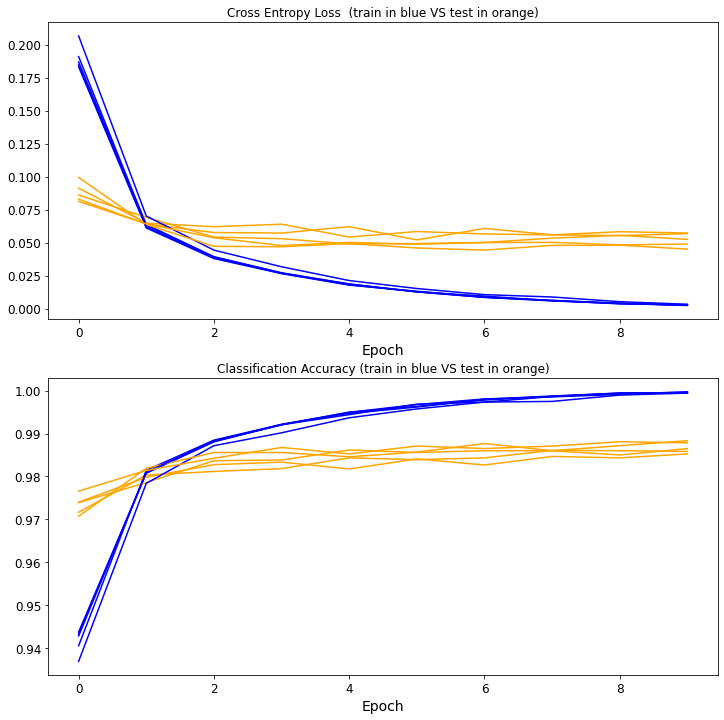

In [165]:
# learning curves
plt.figure(figsize=(12,12))
summarize_diagnostics(histories)

Here we can conclude that the model achieves a good fit, for train and test set. Overfitting does not seem to happen.

Accuracy: mean=98.675 std=0.117, n=5


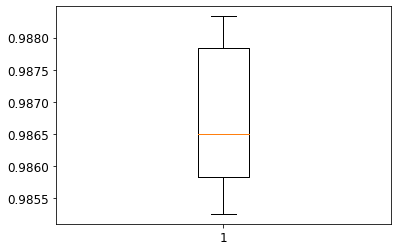

In [166]:
# summarize estimated performance
summarize_performance(scores)

# Ensemble Learning

With the PCA, the accuracy of the models individually are:
- Logistic regression (wihtout clustering): 0.91908
- SVM with optimized parameters: 0.94059
- KNN with optimized parameters: 0.90396
- Random Forest with optimized parameters: 0.94100
- XGBoost with optimized parameters: 0.95286

## Ensemble learning with with hard voting

Here we will try to combine our best three models: SVM, RandomForest, XGBoosting. 

In [10]:
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
svm = OneVsRestClassifier(SVC(gamma="auto", random_state=42), n_jobs=-1)
rf = RandomForestClassifier(n_estimators=200 ,max_depth= 50, random_state=42)
xgb = xgb.XGBClassifier(n_estimators=100, max_depth= 10)

In [61]:
from sklearn.ensemble import VotingClassifier

ens_clf = VotingClassifier( 
                [
                 ('rf', rf),
                 ('xgboost', xgb),
                 ('svm', svm)                 
                ]
             ,voting = 'hard'#only for classifiers
)
ens_clf.fit(X_final, y_train)

C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:53:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=50,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            mo

In [62]:
ens_scores = cross_val_score(ens_clf, X_final, y_train,
                                scoring="accuracy", cv=3, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................................ score: (test=0.961) total time=15.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.9min remaining:    0.0s
C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:32:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................................ score: (test=0.960) total time=16.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 31.9min remaining:    0.0s
C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................................ score: (test=0.964) total time=15.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 47.6min finished


In [63]:
print('Final score of basic Ensemble Learning: '+ str(sum(ens_scores)/len(ens_scores)))

Final score of basic Ensemble Learning: 0.9615


The final accuracy of the basic version is higher then each of the models individually. Please note that it is lower then the accuracy of the Convolutional Neural Network, but the CNN is applied to the full dataset, and not the one reducted with the PCA.

To truly compare them, the ML model should be trained on the full dataset (very loooong).

## Ensemble learning with heterogeneous Stacking

In this part, we will try two different approaches:
- Adding a simple stacking layer as a logistic regression (with sklearn)
- Adding a KNORAU layer and others (with DESlib)

### Stacking with logistic regression

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
estimators=[('rf', rf),
            ('xgboost', xgb),
            ('svm', svm)                 
            ]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
stacking_scores = cross_val_score(clf, X_final[:10000], y_train[:10000],
                                scoring="accuracy", cv=3, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ................................ score: (test=0.952) total time= 4.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ................................ score: (test=0.955) total time= 4.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.1min remaining:    0.0s
C:\Users\louis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ................................ score: (test=0.942) total time= 4.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.2min finished


In [13]:
print(sum(stacking_scores)/len(stacking_scores))

0.9497997490210928


### Stacking with Decision three

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
estimators=[('rf', rf),
            ('xgboost', xgb),
            ('svm', svm)                 
            ]
clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(), n_jobs=-1)
stacking_scores = cross_val_score(clf, X_final[:10000], y_train[:10000],
                                scoring="accuracy", cv=3, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.919) total time= 3.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV] END ................................ score: (test=0.912) total time= 4.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.9min remaining:    0.0s


[CV] END ................................ score: (test=0.905) total time= 4.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.0min finished


In [16]:
print(sum(stacking_scores)/len(stacking_scores))

0.9123993083171543


Both accuracies are slightly lower then the one of the basic ensemble learning model (0.96). But this one was only trained on 10 000 rows, instead of the 60 000 total rows. With more computational power, it might be possible to train it on the full dataset, and beat that model. Please note that the logistic regression stacking layer performed better then the decision tree stacking layer.

### Stacking with the KNORA-U

(For the SVM classifier, we need it to output probabilities instead of hard voting. This increases the computing time by a lot, so we will only fit it on the first 10000 rows for now)

In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

svm = OneVsRestClassifier(SVC(gamma="auto", random_state=42, probability = True), n_jobs=-1)
svm.fit(X_final[:10000], y_train[:10000])

OneVsRestClassifier(estimator=SVC(gamma='auto', probability=True,
                                  random_state=42),
                    n_jobs=-1)

In [18]:
rf = RandomForestClassifier(n_estimators=200 ,max_depth= 50, random_state=42)
rf.fit(X_final, y_train)

RandomForestClassifier(max_depth=50, n_estimators=200, random_state=42)

In [20]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators=100, max_depth= 10)
xgb.fit(X_final, y_train)

C:\Users\louis\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Let's create the pool of classifiers:

In [21]:
#Create your classifiers (they have to be fitted before here)
pool_classifiers = [svm,
                   rf,
                   xgb
                   ]

Here we will try different stacking layers from the DESlib library:

In [28]:
#Initialising a KNORAU layer:
knorau = KNORAU(pool_classifiers)

#Other DES techniques:
kne = KNORAE(pool_classifiers)
desp = DESP(pool_classifiers)
metades = METADES(pool_classifiers, mode='hybrid')

# Or the DCS tewhniques:
ola = OLA(pool_classifiers)
mcb = MCB(pool_classifiers)

For fitting and evaluating the DES methods, we will not use cross val score (too long to compute). Instead, we will directly evaluate them on the test set.

In [29]:
# Fitting the DES techniques
knorau.fit(X_final, y_train)

KNORAU(pool_classifiers=[OneVsRestClassifier(estimator=SVC(gamma='auto',
                                                           probability=True,
                                                           random_state=42),
                                             n_jobs=-1),
                         RandomForestClassifier(max_depth=50, n_estimators=200,
                                                random_state=42),
                         XGBClassifier(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=10,
                                       min_child_weight=1, missing=nan,

In [30]:
kne.fit(X_final, y_train)

KNORAE(pool_classifiers=[OneVsRestClassifier(estimator=SVC(gamma='auto',
                                                           probability=True,
                                                           random_state=42),
                                             n_jobs=-1),
                         RandomForestClassifier(max_depth=50, n_estimators=200,
                                                random_state=42),
                         XGBClassifier(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=10,
                                       min_child_weight=1, missing=nan,

In [31]:
desp.fit(X_final, y_train)

DESP(pool_classifiers=[OneVsRestClassifier(estimator=SVC(gamma='auto',
                                                         probability=True,
                                                         random_state=42),
                                           n_jobs=-1),
                       RandomForestClassifier(max_depth=50, n_estimators=200,
                                              random_state=42),
                       XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, missing=nan,
                           

In [32]:
metades.fit(X_final, y_train)

METADES(mode='hybrid',
        pool_classifiers=[OneVsRestClassifier(estimator=SVC(gamma='auto',
                                                            probability=True,
                                                            random_state=42),
                                              n_jobs=-1),
                          RandomForestClassifier(max_depth=50, n_estimators=200,
                                                 random_state=42),
                          XGBClassifier(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1, colsample_bynode=1,
                                        colsample_bytree=1, gamma=0, gpu_id=-1,
                                        importance_type='gain',
                                        interaction_constraints='',
                                        learning_rate=0.300000012,
                                        max_delta_step=0, max_depth=10,
                                   

In [33]:
ola.fit(X_final, y_train)

OLA(pool_classifiers=[OneVsRestClassifier(estimator=SVC(gamma='auto',
                                                        probability=True,
                                                        random_state=42),
                                          n_jobs=-1),
                      RandomForestClassifier(max_depth=50, n_estimators=200,
                                             random_state=42),
                      XGBClassifier(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=10, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
              

In [34]:
mcb.fit(X_final, y_train)

MCB(pool_classifiers=[OneVsRestClassifier(estimator=SVC(gamma='auto',
                                                        probability=True,
                                                        random_state=42),
                                          n_jobs=-1),
                      RandomForestClassifier(max_depth=50, n_estimators=200,
                                             random_state=42),
                      XGBClassifier(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=10, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
              

In [36]:
#Evaluating the score
print('Knora-u: '+str((knorau.score(X_test, y_test))))
print('Knora-e: '+str((kne.score(X_test, y_test))))
print('DESp: '+str((desp.score(X_test, y_test))))
print('metaDES: '+str((metades.score(X_test, y_test))))
print('ola: '+str((ola.score(X_test, y_test))))
print('mcb: '+str((mcb.score(X_test, y_test))))

Knora-u: 0.96
Knora-e: 0.9592
DESp: 0.9596
metaDES: 0.9604
ola: 0.9533
mcb: 0.9551


The DES methods perform better then simple stacking layers (logisitc regression and decision tree). But they are slightly weaker then the hard voting ensemble learning model (the metaDES is the second best ML model we have in this notebook). This might be due to the fact that de DESlib models are trained with an SVM that is only trained on 10 000 rows.

# Conclusion

## Final accuracy on the test set:

In [64]:
final_model = ens_clf

#Predicting
final_predictions = final_model.predict(X_test)

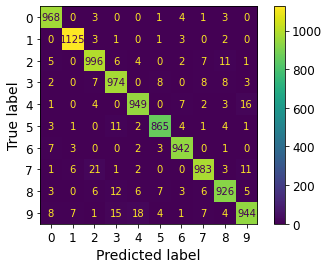

In [66]:
plot_confusion_matrix(final_model, X_test, y_test)

This looks really good, and will help us to determine which images are not classified correctly. (9 and 4, and others).

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Calculate and print precision and recall as percentages
print(accuracy_score(y_test, final_predictions)*100)
#print("Precision: "+ str(round(precision_score(y_test, final_predictions)*100,1))+"%")
#print("Recall: " + str(round(recall_score(y_test, final_predictions)*100,1))+"%")
## Obtain and print F1 score as a percentage
#print("F1 score: " + str(round(f1_score(y_test, final_predictions)*100,1))+"%")

96.72


Their is no overfitting, the test accuracy is even better then the train accuracy!

IMPORTANT: If we had specific requirements about the precision or the recall (for example if we value false positives more then false negatives), we might have used another metric to evaluate our models when fine-tuning them, and evaluate the precision and recall per class.

The best model we got was the ensemble learning one, without stacking. 

Only the deep learning model performed better (0.98), but was trained on the full dataset (with >700 features) instead of the reduced dataset after PCA. The ensemble learning model, with or without stacking, and trained on the full dataset without PCA, might reach that accuracy, but requests more computonial power.


In the next part, we will try to gather more data (create pictures from the ones already in the dataset).

# Improvements of the model

## Data augmentation

Please note that the steps listed here have to be done before the PCA of the pictures.

### Adding rotation and shifting of images with basic python functions, for the ML training

In [92]:
from scipy.ndimage.interpolation import shift

In [93]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

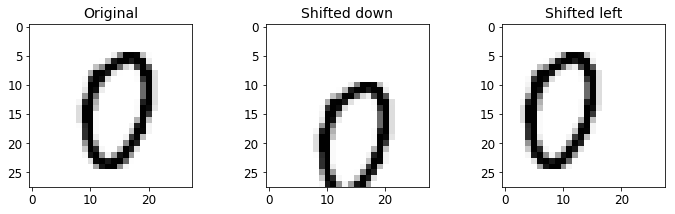

In [94]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [95]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [96]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now the augmented datasets just have to be put through pre-processing, and trained with the best model we found. This will not be done here, as the best model was already very long to train with the basic dataset, but an improvement on the accuracy definetely is to be expected.

### Adding rotation and shifting of images with keras preprocessing, for the deep learning training

Here we only take values for rotations and shiftings that seem reasonable. (Having pictures that are 180 degrees rotated will only mess with our dataset, but having slightly rotated pictures, that is totaaly reasonable. Imagine yourself's handwritting, it might sometime happen that your hand-written digits are a little bit rotated)

In [49]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [59]:
X_train = X / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
Y_train = tf.keras.utils.to_categorical(y, num_classes = 10)

X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))

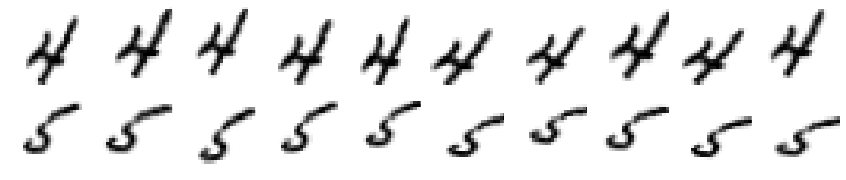

In [61]:
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(20):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

Again, now we just have to apply this to the full dataset, and retrain our deep learning model. This will not be done here, as it is already very long to compute with the basic dataset.

### Training of a Generative Artificial Network 

The objective here is to train two deep learning models. One will try to predict if an input is a digit (the discriminator), and the other will try to generate digits (the generator). They will both work together, and share their inputs and outputs. The objective is that the one that generates the images will improve so much that the model classify them will not be able to tell the difference between original pictures and artificial ones.

In [81]:
import tensorflow as tf
import glob
import imageio
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from IPython import display

#### Preprocessing

In this part, we will only need the training set of MNIST. First we will reshape it as we want, and then normalize it. Finally, we will reshuffle the data for more randomness.

In [61]:
X_gan=X.to_numpy()

In [62]:
X_train_gan, X_gan_test, y_train_gan, y_test_gan = X_gan[:60000], X_gan[60000:], y[:60000], y[60000:]

In [63]:
X_train_gan = X_train_gan.reshape(X_train_gan.shape[0], 28, 28, 1).astype('float32')
X_train_gan = (X_train_gan - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [64]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [65]:
# Batch and shuffle the data
X_train_gan_final = tf.data.Dataset.from_tensor_slices(X_train_gan).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### The generator

In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
# Defining loss for generator
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Here we define the layers of our model:

The generator uses Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1.

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Let's look at what the generator generates without any training.

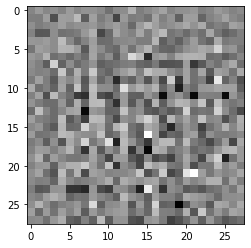

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

This definetely does not look like a hand-written digit, just random noise.

#### The discriminator

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s:

In [24]:
# Defining loss for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Here we define the layers of our discriminator.

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Let's look at how the random image generated by the generator is classified by our discriminator:

(The model will be trained to output positive values for real images, and negative values for fake images)

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00197837]], shape=(1, 1), dtype=float32)


The discriminator outputs the random noise image as not image, which is correct.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Training

In [66]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [43]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [108]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

Let's add a function that saves the state of the digits at each epoch, in order to be able to see the progression at each epoch:

In [97]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('Images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### Visualize Results

Let's look at our generated images!

In [106]:
EPOCHS = 20

The next cell does the work, but can take a very long time to run (for me, 5mn per epoch):

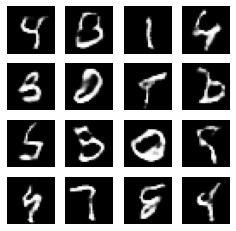

In [109]:
train(X_train_gan_final, EPOCHS)

Let's try to visualize the digits at one epoch:

In [110]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('Images/image_at_epoch_{:04d}.png'.format(epoch_no))

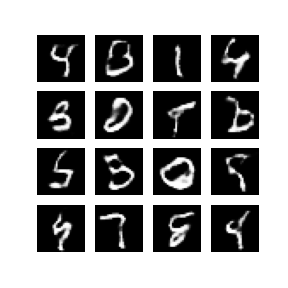

In [111]:
display_image(EPOCHS)

Here we will try to generate a GIF, using the images generated at each epoch, in order to see its progression:

In [114]:
anim_file = 'Images/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('Images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


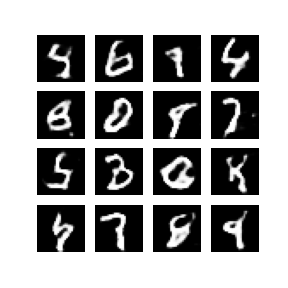

In [115]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Sum up of the notebook

In this notebook, we learned:
- How to import and visualise images
- How to preprocess them, using unsupervised learning (dimensonality reduction)
- How to train complex Machine Learning and Ensemble Learning models
- How to train Deep Learning and Convolutional Neural Network models
- How to generate data from the data we already have using simple shiftings and rotations, and Generative Adversial Networks

# Ressources

I would like to thank:
    
- Aurélien Géron, for his book "Hands On Machine Learning", which I highly recommend
- TensorFlow documentation and tutorials about GANs
- Jason Brownlee, for his tutorials and articles about computer vision with keras
- the DESlib website and documentation